# Data Challenge - Semester 6 Advanced AI - Steven Ly

## 📃 Context
The domain of this data challenge is the food and beverages industry. Specifically, it is about the cafeteria business Den Besterd in Tilburg. This local cafetaria sells typical Dutch fries and snacks and includes sales data of food items.

My innovative idea is to apply deep learning models to predict the optimal timing for selling certain
food items within periods such as a week or month. My goal is to leverage effective deep learning
models so that in the future, new opportunities arise in making deals based on the predictions the
model has made. When certain food items are about to trend, it is possible to promote those items
early on in the trend. This technique could provide a competitive advantage in the food and beverage
industry within our area, as we would be able to implement sales strategies in advance when certain
food items are about to trend.

## 📅 Data
Den Besterd employs the POS system "Sitedish" for local ordering and "Just Eat" otherwise known as "Thuisbezorgd" for food deliveries. Sitedish is a company that provides a POS system and a website in which users can adjust the products, set opening times and download various data. The data of Sitedish and Thuisbezorgd are downloadable through the Sitedish online platform. However, it is not very accessible to download food item data periodically, as this approach misses information about the specific periods when food items were ordered.

Before I started working on this notebook, I developed a web scraper with the python library Selenium for obtaining the daily food item csv data given the inconvenient accessibility of obtaining the data from Sitedish. The script for the web scraper can be found as "selenium-webautomation-daily.py" or "selenium-webautomation-periodically.py".

I have chosen to obtain the archived data from the period between the end of 2021 and April 2024, as the end of 2021 marks the period nearing the end of COVID.

## 📑 Ethics
One of the ethical aspects of my challenge is that my model would be utilized when it lacks precision
and trustworthiness. If the model generates false predictions and the users subsequently end up
making the wrong decision, it could result in financial losses. Additionally, feeding customer data into
the AI model raises privacy concerns. Proper anonymization of sensitive customer information is
crucial.

## The code

We firstly analyze the dataset of the POS system Sitedish. The data is nested within the folder directory 'Data/POS_daily' and is structured as "{system}__{start_date}". In the second code cell below, we will gather all the daily .csv data from the folder directory and construct a dataframe that captures information from each CSV file.

In [1]:
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt

In [2]:
folder_path = 'Data/POS_daily'

# Use glob to get all CSV files in the folder
csv_files = glob.glob(f'{folder_path}/*.csv')

# An empty list to store the DataFrames
df_list = []

# The csv files from the data folder are structured as "{system}__{start_date}". The regular expression extracts the date information from the filename.
pattern = re.compile(r'POS__(\d{4}-\d{2}-\d{2})')

# Loop over the list of files and read each file into a DataFrame
for file in csv_files:
    match = pattern.search(file)
    if match:
        csv_date_start = match.groups()[0]

        df = pd.read_csv(file)

        df['date'] = csv_date_start
        df['date'] = pd.to_datetime(df['date'])
        # temp_year = df['date'].dt.year
        # temp_week = df['date'].dt.isocalendar().week
        # df['yearly_week'] = temp_year.astype(str) + '-W' + temp_week.astype(str).str.zfill(2)
        
        df_list.append(df)
    else:
        print(f"mismatch: {file}")

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(df_list)
combined_df.drop('laatst_besteld', inplace=True, axis=1) # Dropped this column since it is not relevant for analyzing trending food item data

combined_df

,gerecht,prijs_€,aantal_bestellingen,date
0,Frikandel,1.80,20,2021-07-01
1,Friet,2.00,14,2021-07-01
2,Friet speciaal,3.10,12,2021-07-01
3,Frikandel speciaal,3.00,11,2021-07-01
4,Friet mayonaise,2.55,8,2021-07-01
...,...,...,...,...
34,Red Bull,2.75,1,2024-04-30
35,Sitostick,2.80,1,2024-04-30
36,Speksnack,2.40,1,2024-04-30
37,Sundae Caramel topper,3.25,1,2024-04-30


In [3]:
# Settings the index to be the date for analyzing time series data
combined_df.set_index('date', inplace=True)

start_date = combined_df.index.min()
end_date = combined_df.index.max()

print("First Date:", start_date.strftime("%Y %m %d"))
print("Last Date:", end_date.strftime("%Y %m %d"))

First Date: 2021 07 01
Last Date: 2024 04 30


As we can see the data is obtained from the period between July 1st 2021 (2021-07-01) and April 30th 2024 (2024-04-30). The data features every date as the index and includes columns for the food items sold, their prices, and the quantity sold.

In the codecell below I have made a helper function for plotting out a line plot with matplotlib.

In [4]:
def create_plot(index, dataframe, label="Data", xlabel="X", ylabel="Y", title=None, xlim=None, ylim=None, figsize=(12,6), legend=False, highlights=None):
    plt.figure(figsize=figsize)
    plt.plot(index, dataframe, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid(True)
    plt.tight_layout()
    if legend:
        plt.legend()
    if highlights:
        start, end = highlights
        plt.axvspan(start, end, facecolor='yellow', alpha=0.5, hatch='/', edgecolor='red', linewidth=2)

    plt.show()

In the codecell we can plot out the amount of orders given the period between 2021-07-01 and 2021-12-31. This is first month of the dataset. 

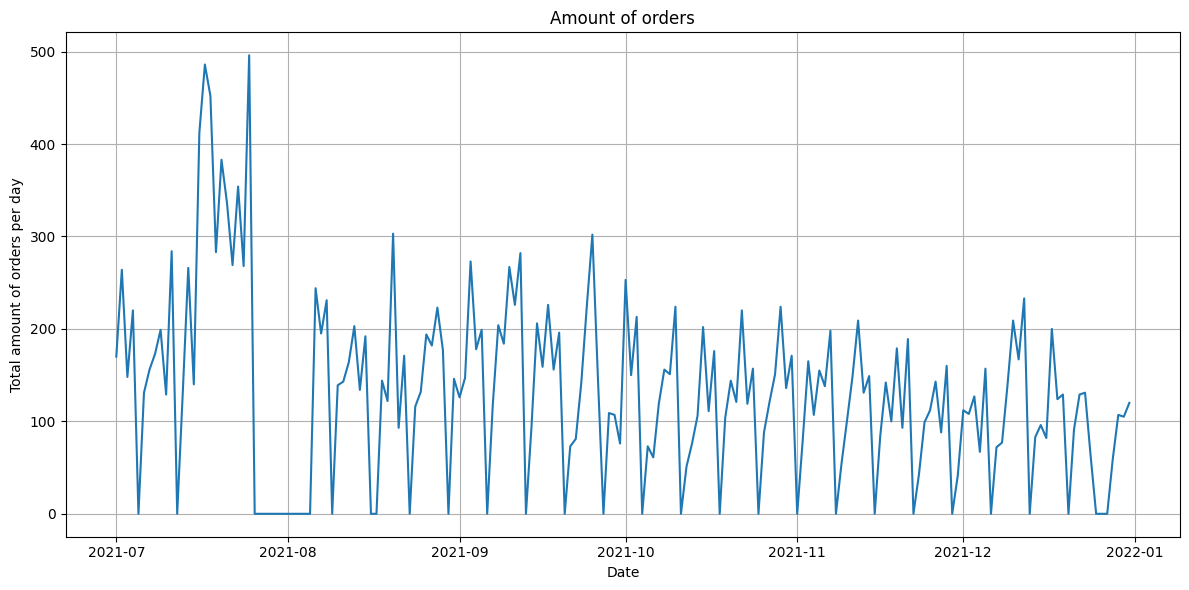

In [5]:
# Group by orders and calculate the total amount of orders for each date
orders_df = combined_df.groupby(combined_df.index).apply(
    lambda x: x['aantal_bestellingen'].sum()
)

date_range = pd.date_range(start='2021-07-01', end='2021-12-31')
orders_df = orders_df.reindex(date_range, fill_value=0)

create_plot(orders_df.index, orders_df, "Total amount of orders per day", "Date", "Total amount of orders per day", "Amount of orders")

As we can see there is a substantial increase of amount of orders after 2021-07-16, this is not an outlier since this week it was Kermis in Tilburg which is an event that attracts a lot of customers. Additionally, every 7th day the total amount of orders per day decreases to 0 as this is the non-working-day of Den Besterd.

In the codeblock below we analyse the revenue as well, which is the price multiplied by the amount of orders per food item. 

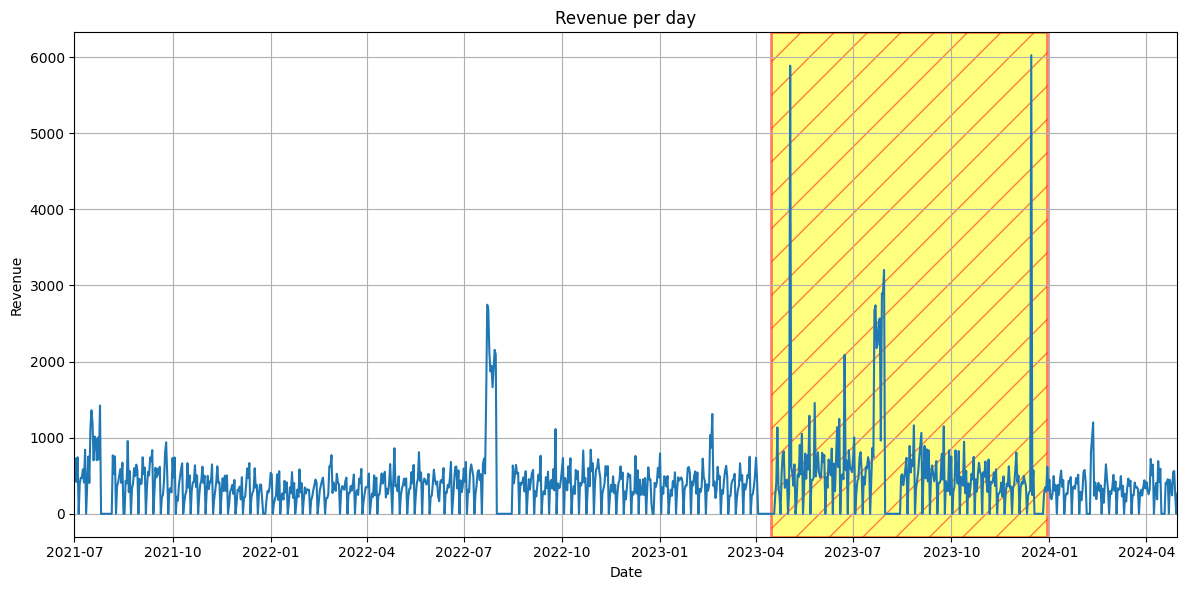

In [6]:
# Group by date and calculate the total revenue for each date
revenue_df = combined_df.groupby(combined_df.index).apply(
    lambda x: (x['prijs_€'] * x['aantal_bestellingen']).sum()
)

date_range = pd.date_range(start=start_date, end=end_date)
revenue_df = revenue_df.reindex(date_range, fill_value=0)


create_plot(revenue_df.index, revenue_df, "Revenue per day", "Date", "Revenue", "Revenue per day", xlim=(start_date, end_date), highlights=('2023-04-15','2023-12-30'))

The yellow highlighted zone in the line plot indicates the region with significant outliers. As we can see there are two points that stand out prominently. In the code cell below, we visualize what those two points represent.

In [7]:
revenue_df.sort_values(ascending=False)[:5]

2023-12-15    6024.25
2023-05-03    5887.10
2023-07-30    3203.50
2023-07-28    2896.90
2023-07-29    2896.25
dtype: float64

In [8]:
combined_df.loc['2023-12-15']

,gerecht,prijs_€,aantal_bestellingen
date,,,
2023-12-15,Frikandel speciaal,3.25,151
2023-12-15,Friet,2.20,139
2023-12-15,Frikandel,1.95,126
2023-12-15,Friet speciaal,3.70,89
2023-12-15,Kroket,1.95,85
...,...,...,...
2023-12-15,Sorbet Aardbeien,4.00,1
2023-12-15,Sorbet Kersen,4.00,1
2023-12-15,Spa Rood,2.50,1


I have done an analysis of the two points, which are 2023-12-15 and 2023-05-03. December 15th 2023 represents "Koningsrijkdag". It was not evident what special day April 3rd 2023 was. 

In [9]:
combined_df = combined_df.drop(index=pd.to_datetime(['2023-12-15','2023-05-03']))

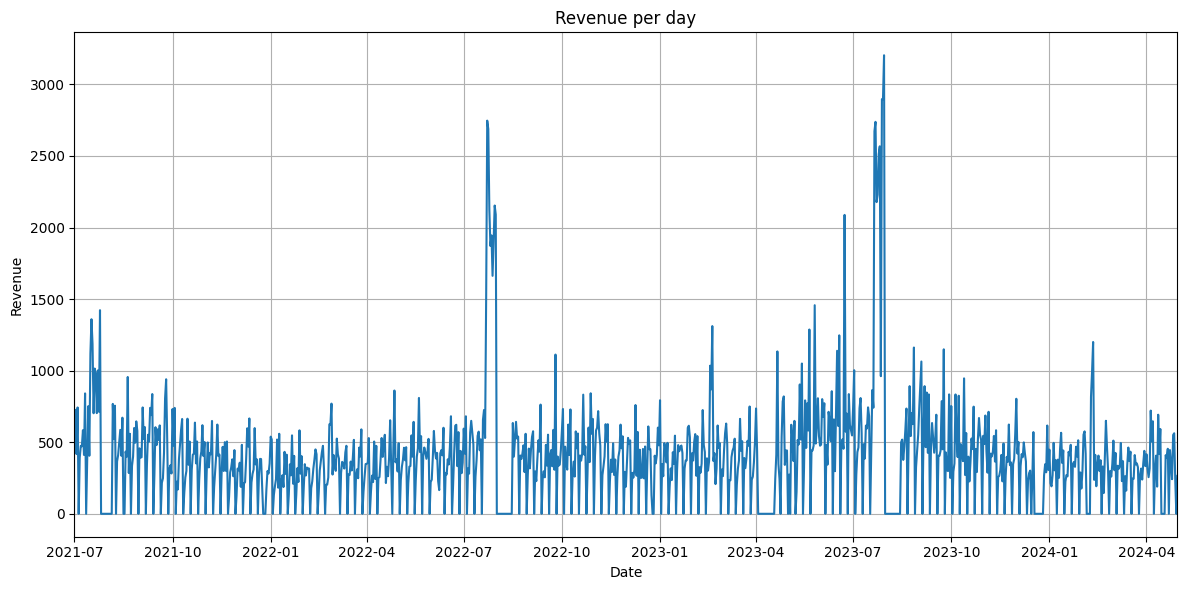

In [10]:
revenue_df = combined_df.groupby(combined_df.index).apply(
    lambda x: (x['prijs_€'] * x['aantal_bestellingen']).sum()
)

date_range = pd.date_range(start=start_date, end=end_date)
revenue_df = revenue_df.reindex(date_range, fill_value=0)

create_plot(revenue_df.index, revenue_df, "Revenue per day", "Date", "Revenue", "Revenue per day", xlim=(start_date, end_date))

In [11]:
total_orders = combined_df.groupby('gerecht')['aantal_bestellingen'].sum()
top_10_items = total_orders.nlargest(10).index
top_10_items

Index(['Frikandel speciaal', 'Friet', 'Frikandel', 'Friet speciaal', 'Kroket',
       'Friet mayonaise', 'Friet satésaus', 'Kaassouflé                  ',
       'Friet stoofvlees', 'Mexicano'],
      dtype='object', name='gerecht')

In [12]:
monthly_orders = combined_df.groupby([pd.Grouper(freq='ME'), 'gerecht']).sum().reset_index()
monthly_orders = monthly_orders.drop('prijs_€', axis=1)
monthly_orders

,date,gerecht,aantal_bestellingen
0,2021-07-31,Picanto,54
1,2021-07-31,3D beker,26
2,2021-07-31,Alaska fish Burger,5
3,2021-07-31,Appelsap,14
4,2021-07-31,Asianbox chickenMixed,5
...,...,...,...
5292,2024-04-30,monster,1
5293,2024-04-30,obliehoorn,39
5294,2024-04-30,portie Belse Mayo,14
5295,2024-04-30,portie ketchup,4


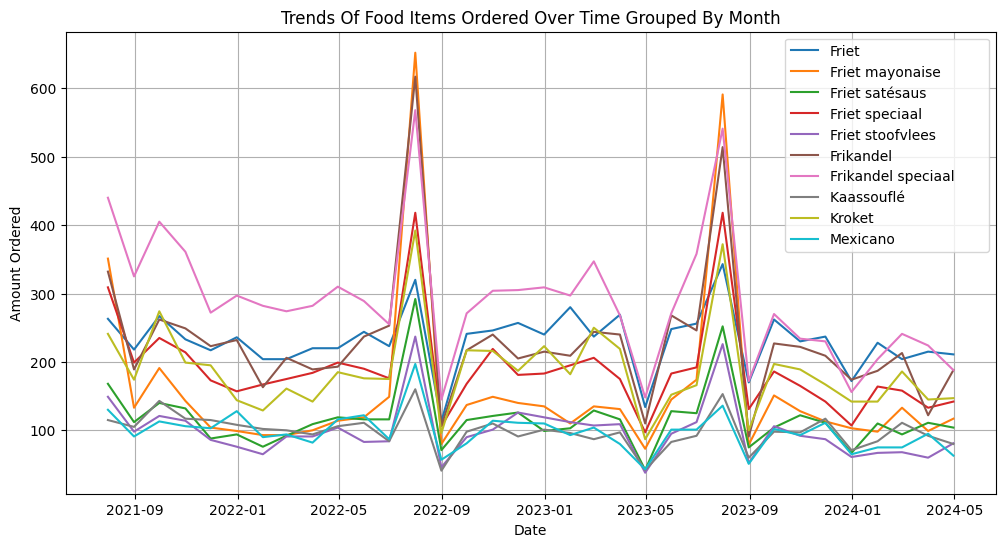

In [13]:
filtered_df = monthly_orders[monthly_orders['gerecht'].isin(top_10_items)]

# Pivot the DataFrame
pivot_df = filtered_df.pivot_table(index='date', columns='gerecht', values='aantal_bestellingen', aggfunc='sum')

plt.figure(figsize=(12, 6))

for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Amount Ordered')
plt.title('Trends Of Food Items Ordered Over Time Grouped By Month')
plt.legend()
plt.grid(True)

plt.show()